In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from glob import glob

## Plot Config

In [2]:
dataset_names = {
    "german" : "German Credit",
    "compas" : "COMPAS",
    "adult" : "Adult",
    "acsincome" : "ACSIncome"
}
methods_color = {
    "LGBMClassifier" : "#ffd92f",
    "FairGBMClassifier" : "#fc8d62",
    "MinMaxFair" : "#a6d854",
    "MinMaxFair_tpr" : "#a6d854",
    "M2FGB_grad" : "#8da0cb",
    "M2FGB_grad_tpr" : "#8da0cb",
    "M2FGB_grad_pr" : "#8da0cb",
    #"M2FGB" : "#66c2a5",
    "MinimaxPareto" : "pink"
}
methods_names = {
    "LGBMClassifier" : "LGBM",
    "FairGBMClassifier" : "FairGBM",
    "M2FGB_grad" : "M²FGB",
    "M2FGB_grad_tpr" : "M²FGB (tpr)",
    "M2FGB_grad_pr" : "M²FGB (pr)",
    #"M2FGB" : "M²FGB opt.",
    "MinMaxFair" : "MinMaxFair",
    "MinMaxFair_tpr" : "MinMaxFair (tpr)",
    "MinimaxPareto" : "MMPF"
}

handles = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items()
]

handles_tpr = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "tpr" in key or "LGBM" in key
]
handles_pr = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "_pr" in key or "LGBM" in key
]

## Functions

In [3]:
SEED = 0

In [12]:
def summary_experiment(dataset_name, model_name, path, fair_metric = "min_bal_acc", max_models = None, verbose = False):
    results = []

    n_folds = len(glob(path + "validation_fold_*.csv"))
    # For each fold
    for i in range(n_folds):
        results_val = pd.read_csv(path + f"validation_fold_{i}.csv")

        if verbose and i == 0:
            print(f"{model_name}, {dataset_name}, {n_folds} n_folds, {results_val.model.unique().shape[0]} models")

        # sample models if there is a limit of max_models
        if i == 0: 
            model_list = results_val.model.unique()
            if max_models is not None and len(model_list) > max_models:
                np.random.seed(SEED)
                model_list = np.random.choice(model_list, size = max_models, replace = False)
        if max_models is not None:
            results_val = results_val[results_val.model.isin(model_list)]

        # adjust fairness metric to be better when closer to 1
        if fair_metric in ["eod", "spd"]:
            results_val[fair_metric] = 1 - np.abs(results_val[fair_metric])
        results_val["score"] = results_val["alpha"] * results_val["bal_acc"] + (1 - results_val["alpha"]) * (results_val[fair_metric])


        # identify best model for each alpha based on score
        results_val = results_val.groupby("alpha").apply(lambda x: x.sort_values("score", ascending=False).head(1), include_groups = False).reset_index()
        alpha_list = results_val.alpha.tolist()
        best_models = results_val.model.tolist()


        # select the same models for the test set
        results_test = pd.read_csv(path + f"test_fold_{i}.csv")
        if fair_metric in ["eod", "spd"]:
            results_test[fair_metric] = 1 - np.abs(results_test[fair_metric])
        
        trials = pd.read_csv(path + f"trials_fold_{i}.csv")
        trials["duration"] = pd.to_timedelta(trials["duration"]).dt.total_seconds()

        for alpha, m in zip(alpha_list, best_models):
            best_model = results_test[((results_test.alpha == alpha) & (results_test.model == m))]
            results.append({
                "fold" : i,
                "alpha" : alpha,
                "bal_acc" : best_model.bal_acc.values[0],
                fair_metric : best_model[fair_metric].values[0],
                "dataset" : dataset_name,
                "model" : model_name,
                "time" : trials.duration.values[m],
            })

    results = pd.DataFrame(results).groupby("alpha").agg({
        "dataset" : "first",
        "model" : "first",
        "bal_acc" : "mean",
        fair_metric : "mean",
        "time" : "mean"
    }).reset_index()
    return results

## Bal Acc

M2FGB_grad, german, 10 n_folds, 500 models
FairGBMClassifier, german, 10 n_folds, 500 models
MinMaxFair, german, 10 n_folds, 100 models
LGBMClassifier, german, 10 n_folds, 500 models
MinimaxPareto, german, 10 n_folds, 100 models
M2FGB_grad, german, 10 n_folds, 500 models
FairGBMClassifier, german, 10 n_folds, 500 models
MinMaxFair, german, 10 n_folds, 100 models
LGBMClassifier, german, 10 n_folds, 500 models
MinimaxPareto, german, 10 n_folds, 100 models
M2FGB_grad, german, 10 n_folds, 500 models
FairGBMClassifier, german, 10 n_folds, 500 models
MinMaxFair, german, 10 n_folds, 100 models
LGBMClassifier, german, 10 n_folds, 500 models
MinimaxPareto, german, 10 n_folds, 100 models
M2FGB_grad, compas, 10 n_folds, 500 models
FairGBMClassifier, compas, 10 n_folds, 500 models
MinMaxFair, compas, 10 n_folds, 100 models
LGBMClassifier, compas, 10 n_folds, 500 models
MinimaxPareto, compas, 10 n_folds, 100 models
M2FGB_grad, compas, 10 n_folds, 500 models
FairGBMClassifier, compas, 10 n_folds, 50

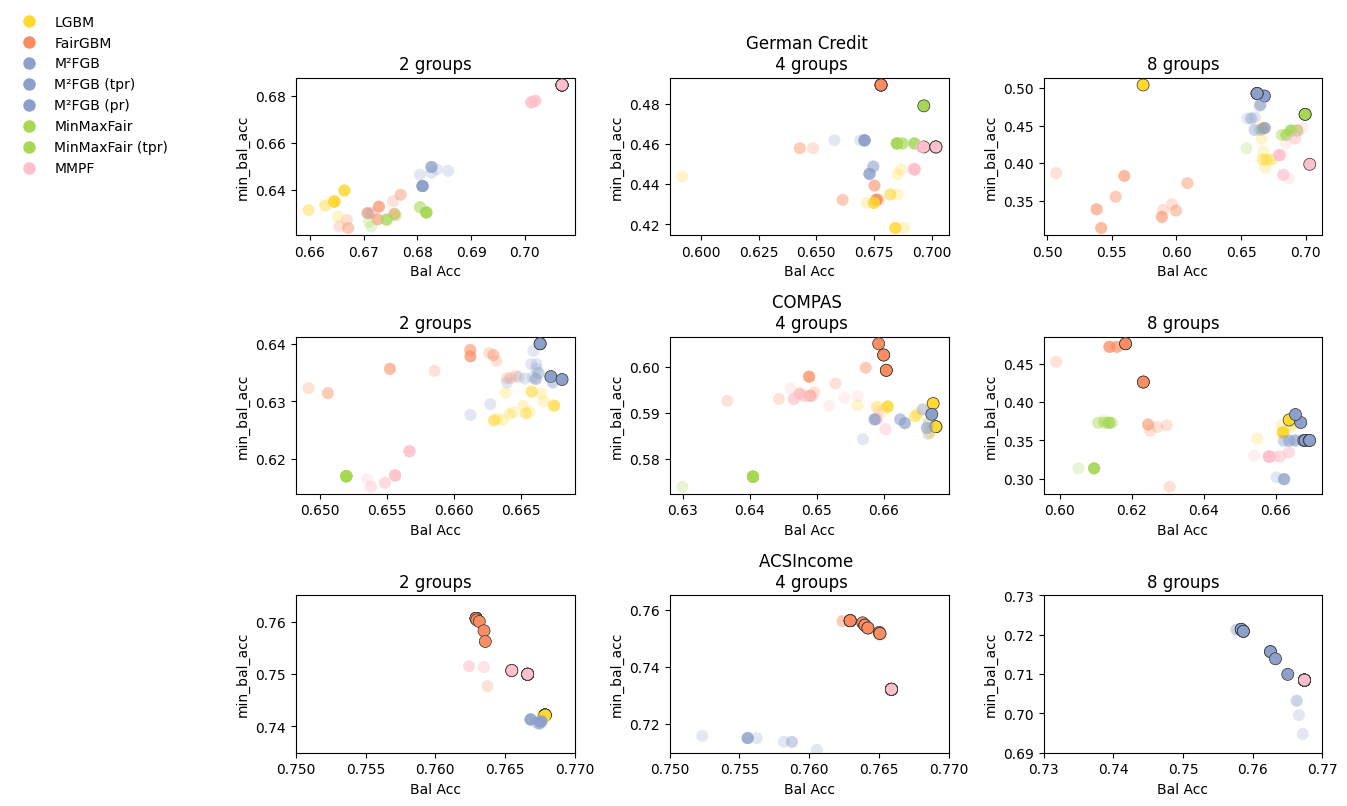

In [13]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (14, 8))

methods = [
    "M2FGB_grad",
    "FairGBMClassifier",
    "MinMaxFair",
    "LGBMClassifier",
    "MinimaxPareto"
]
fair_metric = "min_bal_acc"
max_models = 100
for jj, dataset_name in enumerate(["german", "compas",  "acsincome"]):
    for ii, n_groups in enumerate([2, 4, 8]):
        results = []
        for model_name in methods:
            path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
            try:
                results.append(summary_experiment(dataset_name, model_name, path, fair_metric, max_models=max_models, verbose = True))
            except:
                pass

        results = pd.concat(results)

        dominated = []
        for i, row in results.iterrows():
            is_dominated = False
            for j, row2 in results.iterrows():
                if i == j:
                    continue
                if row["bal_acc"] < row2["bal_acc"] and row[fair_metric] < row2[fair_metric]:
                    is_dominated = True
                    break
            dominated.append(is_dominated)
        results["dominated"] = dominated


        for model_name in methods:
            results_m = results[results.model == model_name]
            if results_m.shape[0] == 0:
                continue

            axs[jj, ii].scatter(
                results_m.bal_acc,
                results_m[fair_metric],
                c = methods_color[model_name],
                s = 75,
                alpha = [0.25 if d else 1 for d in results_m.dominated],
                label = model_name,
                lw = [0 if d else 0.5 for d in results_m.dominated],
                zorder = 10 if model_name != "M2FGB_grad" else 100,
                ec = ["#ffffff" if d else "#303030" for d in results_m.dominated],

            )

        
        #axs[ii].legend()
        axs[jj, ii].set_xlabel("Bal Acc")
        axs[jj, ii].set_ylabel(fair_metric)
        #axs[jj, ii].grid(True)
        if ii == 0 and jj == 0:
            axs[jj, ii].legend(handles=handles, loc="lower left", bbox_to_anchor=(-1.05, 0.3), frameon=False)
        
        if ii == 1:
            axs[jj, ii].set_title(f"{dataset_names[dataset_name]} \n {n_groups} groups")
        else:
            axs[jj, ii].set_title(f"{n_groups} groups")
        

axs[2, 0].set_xlim([0.75, 0.77])
axs[2, 0].set_ylim([0.735, 0.765])

axs[2, 1].set_xlim([0.75, 0.77])
axs[2, 1].set_ylim([0.71, 0.765])

axs[2, 2].set_xlim([0.73, 0.77])
axs[2, 2].set_ylim([0.69, 0.73])


plt.tight_layout()
#plt.savefig("../figs/results_datasets.pdf", dpi = 300)
plt.show()

In [45]:
def summary_alpha(selected_alpha, dataset_name, model_name, path, fair_metric = "min_bal_acc", max_models = None):
    results = []

    n_folds = len(glob(path + "validation_fold_*.csv"))
    # For each fold
    for i in range(n_folds):
        results_val = pd.read_csv(path + f"validation_fold_{i}.csv")

        # sample models if there is a limit of max_models
        if i == 0: 
            model_list = results_val.model.unique()
            if max_models is not None and len(model_list) > max_models:
                model_list = np.random.choice(model_list, size = max_models, replace = False)
        if max_models is not None:
            results_val = results_val[results_val.model.isin(model_list)]

        # adjust fairness metric to be better when closer to 1
        if fair_metric in ["eod", "spd"]:
            results_val[fair_metric] = 1 - np.abs(results_val[fair_metric])
        results_val["score"] = results_val["alpha"] * results_val["bal_acc"] + (1 - results_val["alpha"]) * (results_val[fair_metric])


        # identify best model for each alpha based on score
        results_val = results_val.groupby("alpha").apply(lambda x: x.sort_values("score", ascending=False).head(1), include_groups = False).reset_index()
        alpha_list = results_val.alpha.tolist()
        best_models = results_val.model.tolist()


        # select the same models for the test set
        results_test = pd.read_csv(path + f"test_fold_{i}.csv")
        if fair_metric in ["eod", "spd"]:
            results_test[fair_metric] = 1 - np.abs(results_test[fair_metric])
        
        trials = pd.read_csv(path + f"trials_fold_{i}.csv")
        trials["duration"] = pd.to_timedelta(trials["duration"]).dt.total_seconds()

        for alpha, m in zip(alpha_list, best_models):
            best_model = results_test[((results_test.alpha == alpha) & (results_test.model == m))]
            results.append({
                "fold" : i,
                "alpha" : alpha,
                "bal_acc" : best_model.bal_acc.values[0],
                fair_metric : best_model[fair_metric].values[0],
                "dataset" : dataset_name,
                "model" : model_name,
                "time" : trials.duration.values[m],
            })

    results_mean = pd.DataFrame(results).groupby("alpha").agg({
        "dataset" : "first",
        "model" : "first",
        "bal_acc" : "mean",
        fair_metric : "mean",
        "time" : "mean"
    }).reset_index()

    results_std = pd.DataFrame(results).groupby("alpha").agg({
        "dataset" : "first",
        "model" : "first",
        "bal_acc" : "std",
        fair_metric : "std",
        "time" : "std"
    }).reset_index()

    results_mean = results_mean[results_mean.alpha == selected_alpha].round(2)
    results_std = results_std[results_std.alpha == selected_alpha].round(2)

    results = results_mean.merge(results_std, on = ["dataset", "model", "alpha"], suffixes = ("_mean", "_std"))
    results["bal_acc"] = "$" + results["bal_acc_mean"].astype(str) + " (\pm " + results["bal_acc_std"].astype(str) + ")$"
    results[fair_metric] = "$" + results[fair_metric + "_mean"].astype(str) + " (\pm " + results[fair_metric + "_std"].astype(str) + ")$"
    results["time"] = "$" + results["time_mean"].astype(str) + " (\pm " + results["time_std"].astype(str) + ")$"

    columns = ["alpha", "dataset", "model", "bal_acc", 	fair_metric, "time"]
    results = results[columns]
    return results

In [ ]:
results = []

methods = [
    "M2FGB_grad",
    "FairGBMClassifier",
    "MinMaxFair",
    "LGBMClassifier",
    "MinimaxPareto"
]
n_groups = 8
error = 0
for dataset_name in ["german", "compas", "acsincome"]:
    for model_name in methods:
        path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
        try:
            results.append(summary_alpha(0.5, dataset_name, model_name, path))
        except:
            error += 1
results = pd.concat(results)

In [44]:
results

,alpha,dataset,model,bal_acc,min_bal_acc,time
0,0.5,german,M2FGB_grad,$0.67 (\pm 0.02)$,$0.42 (\pm 0.09)$,$2.42 (\pm 1.33)$
0,0.5,german,FairGBMClassifier,$0.62 (\pm 0.05)$,$0.32 (\pm 0.19)$,$0.16 (\pm 0.08)$
0,0.5,german,MinMaxFair,$0.69 (\pm 0.04)$,$0.44 (\pm 0.17)$,$41.09 (\pm 33.56)$
0,0.5,german,LGBMClassifier,$0.7 (\pm 0.03)$,$0.43 (\pm 0.08)$,$0.37 (\pm 0.3)$
0,0.5,german,MinimaxPareto,$0.68 (\pm 0.05)$,$0.41 (\pm 0.16)$,$21.48 (\pm 15.59)$
0,0.5,compas,M2FGB_grad,$0.66 (\pm 0.02)$,$0.41 (\pm 0.2)$,$6.56 (\pm 4.89)$
0,0.5,compas,FairGBMClassifier,$0.64 (\pm 0.02)$,$0.37 (\pm 0.22)$,$0.38 (\pm 0.27)$
0,0.5,compas,MinMaxFair,$0.61 (\pm 0.02)$,$0.37 (\pm 0.26)$,$53.97 (\pm 55.66)$
0,0.5,compas,LGBMClassifier,$0.66 (\pm 0.02)$,$0.35 (\pm 0.23)$,$0.2 (\pm 0.16)$
0,0.5,compas,MinimaxPareto,$0.66 (\pm 0.02)$,$0.33 (\pm 0.25)$,$17.05 (\pm 12.95)$


## SPD

LGBMClassifier, german, 10 n_folds, 100 models
M2FGB_grad_pr, german, 10 n_folds, 100 models
LGBMClassifier, german, 10 n_folds, 100 models
M2FGB_grad_pr, german, 10 n_folds, 100 models
LGBMClassifier, compas, 10 n_folds, 100 models
M2FGB_grad_pr, compas, 10 n_folds, 100 models
LGBMClassifier, compas, 10 n_folds, 100 models
M2FGB_grad_pr, compas, 10 n_folds, 100 models
LGBMClassifier, acsincome, 10 n_folds, 100 models
M2FGB_grad_pr, acsincome, 10 n_folds, 100 models
LGBMClassifier, acsincome, 10 n_folds, 100 models
M2FGB_grad_pr, acsincome, 10 n_folds, 100 models


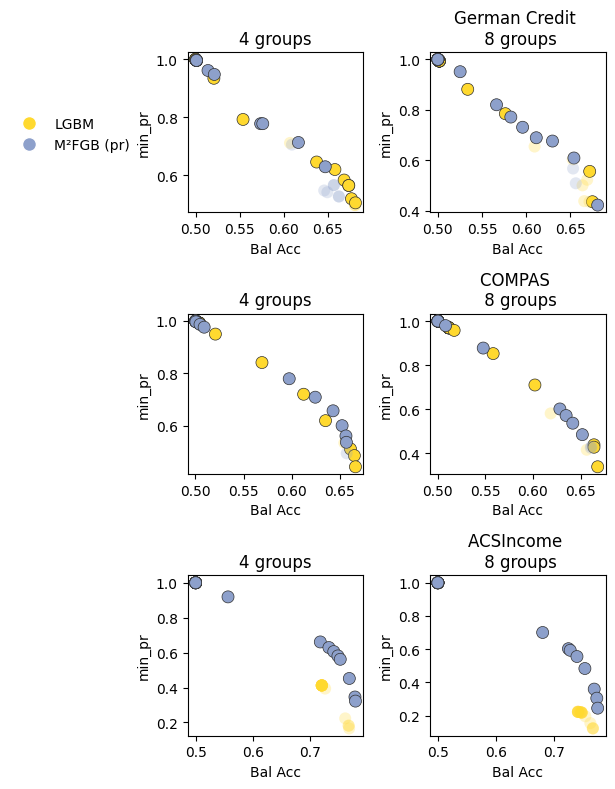

In [5]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (7, 8))

methods = [
    "LGBMClassifier",
    "M2FGB_grad_pr",
]
fair_metric = "min_pr"
max_models = 100
for jj, dataset_name in enumerate(["german", "compas",  "acsincome"]):
    for ii, n_groups in enumerate([4, 8]):
        results = []
        for model_name in methods:
            path = f"../results/experiment_{n_groups}_pr/{dataset_name}/{model_name}/"
            results.append(summary_experiment(dataset_name, model_name, path, fair_metric, max_models=max_models, verbose = True))

        results = pd.concat(results)

        dominated = []
        for i, row in results.iterrows():
            is_dominated = False
            for j, row2 in results.iterrows():
                if i == j:
                    continue
                if row["bal_acc"] < row2["bal_acc"] and row[fair_metric] < row2[fair_metric]:
                    is_dominated = True
                    break
            dominated.append(is_dominated)
        results["dominated"] = dominated


        for model_name in methods:
            results_m = results[results.model == model_name]

            axs[jj, ii].scatter(
                results_m.bal_acc,
                results_m[fair_metric],
                c = methods_color[model_name],
                s = 75,
                alpha = [0.25 if d else 1 for d in results_m.dominated],
                label = model_name,
                lw = [0 if d else 0.5 for d in results_m.dominated],
                zorder = 10 if model_name != "M2FGB_grad" else 100,
                ec = ["#ffffff" if d else "#303030" for d in results_m.dominated],

            )

        
        #axs[ii].legend()
        axs[jj, ii].set_xlabel("Bal Acc")
        axs[jj, ii].set_ylabel(fair_metric)
        #axs[jj, ii].grid(True)
        if ii == 0 and jj == 0:
            axs[jj, ii].legend(handles=handles_pr, loc="lower left", bbox_to_anchor=(-1.05, 0.3), frameon=False)
        
        if ii == 1:
            axs[jj, ii].set_title(f"{dataset_names[dataset_name]} \n {n_groups} groups")
        else:
            axs[jj, ii].set_title(f"{n_groups} groups")
        


plt.tight_layout()
#plt.savefig("../figs/results_datasets.pdf", dpi = 300)
plt.show()

## TPR

LGBMClassifier, german, 10 n_folds, 100 models
M2FGB_grad_tpr, german, 10 n_folds, 100 models
MinMaxFair_tpr, german, 10 n_folds, 100 models
LGBMClassifier, german, 10 n_folds, 100 models
M2FGB_grad_tpr, german, 10 n_folds, 100 models
MinMaxFair_tpr, german, 10 n_folds, 100 models
LGBMClassifier, compas, 10 n_folds, 100 models
M2FGB_grad_tpr, compas, 10 n_folds, 100 models
MinMaxFair_tpr, compas, 10 n_folds, 100 models
LGBMClassifier, compas, 10 n_folds, 100 models
M2FGB_grad_tpr, compas, 10 n_folds, 100 models
MinMaxFair_tpr, compas, 10 n_folds, 100 models
LGBMClassifier, acsincome, 10 n_folds, 100 models
M2FGB_grad_tpr, acsincome, 10 n_folds, 100 models
LGBMClassifier, acsincome, 10 n_folds, 100 models
M2FGB_grad_tpr, acsincome, 8 n_folds, 100 models


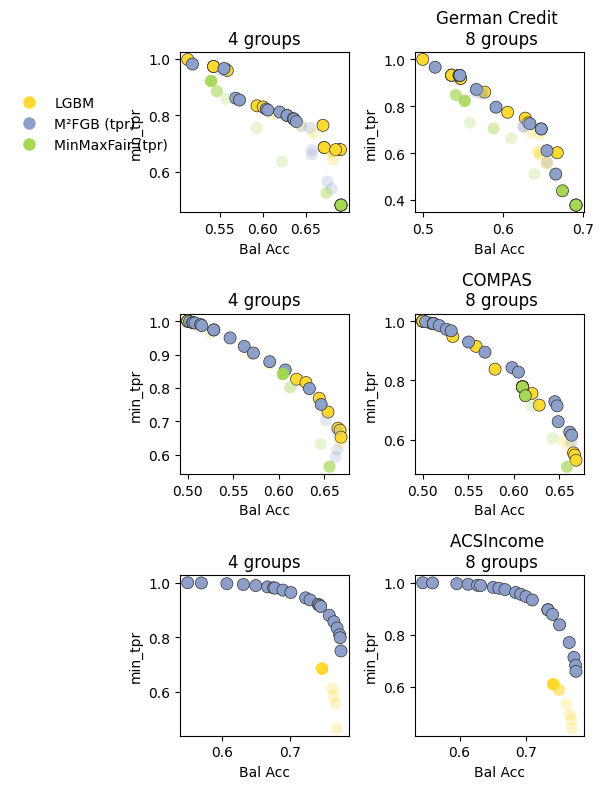

In [7]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (7, 8))

methods = [
    "LGBMClassifier",
    "M2FGB_grad_tpr",
    "MinMaxFair_tpr"
]
fair_metric = "min_tpr"
max_models = 100
for jj, dataset_name in enumerate(["german", "compas",  "acsincome"]):
    for ii, n_groups in enumerate([4, 8]):
        results = []
        for model_name in methods:
            path = f"../results/experiment_{n_groups}_tpr/{dataset_name}/{model_name}/"
            try:
                results.append(summary_experiment(dataset_name, model_name, path, fair_metric, max_models=max_models, verbose = True))
            except:
                pass

        results = pd.concat(results)

        dominated = []
        for i, row in results.iterrows():
            is_dominated = False
            for j, row2 in results.iterrows():
                if i == j:
                    continue
                if row["bal_acc"] < row2["bal_acc"] and row[fair_metric] < row2[fair_metric]:
                    is_dominated = True
                    break
            dominated.append(is_dominated)
        results["dominated"] = dominated


        for model_name in methods:
            results_m = results[results.model == model_name]
            if results_m.shape[0] == 0:
                continue

            axs[jj, ii].scatter(
                results_m.bal_acc,
                results_m[fair_metric],
                c = methods_color[model_name],
                s = 75,
                alpha = [0.25 if d else 1 for d in results_m.dominated],
                label = model_name,
                lw = [0 if d else 0.5 for d in results_m.dominated],
                zorder = 10 if model_name != "M2FGB_grad" else 100,
                ec = ["#ffffff" if d else "#303030" for d in results_m.dominated],

            )

        
        #axs[ii].legend()
        axs[jj, ii].set_xlabel("Bal Acc")
        axs[jj, ii].set_ylabel(fair_metric)
        #axs[jj, ii].grid(True)
        if ii == 0 and jj == 0:
            axs[jj, ii].legend(handles=handles_tpr, loc="lower left", bbox_to_anchor=(-1.05, 0.3), frameon=False)
        
        if ii == 1:
            axs[jj, ii].set_title(f"{dataset_names[dataset_name]} \n {n_groups} groups")
        else:
            axs[jj, ii].set_title(f"{n_groups} groups")
        


plt.tight_layout()
#plt.savefig("../figs/results_datasets.pdf", dpi = 300)
plt.show()